<a href="https://colab.research.google.com/github/Djayana1/Computater_Vision/blob/main/Projeto_Vis%C3%A3o_Computacional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### PROJETO DE VISÃO COMPUTACIONAL 01


Projeto voltado para a detecção de celulas de tumores.

In [ ]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
import csv
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_folder = '/content/drive/MyDrive/PÓS CIÊNCIAS DE DADOS - UFPE/VISÃO COMPUTACIONAL/train'
test_folder = '/content/drive/MyDrive/PÓS CIÊNCIAS DE DADOS - UFPE/VISÃO COMPUTACIONAL/test'
val_folder = '/content/drive/MyDrive/PÓS CIÊNCIAS DE DADOS - UFPE/VISÃO COMPUTACIONAL/val'

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
train_data = datasets.ImageFolder(train_folder, transform=transform)
val_data = datasets.ImageFolder(val_folder, transform=transform)

In [ ]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.files = os.listdir(root_dir)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.files[idx])
        image = Image.open(img_path)
        dummy_label = 0
        if self.transform:
            image = self.transform(image)

        return image, dummy_label

In [ ]:
test_data = TestDataset(test_folder, transform=transform)

In [ ]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [ ]:
import torch.nn as nn

class TumorClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super(TumorClassifierCNN, self).__init__()

        # Camada convolucional 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.leaky_relu1 = nn.LeakyReLU(0.01)  # Alteração aplicada aqui
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Camada convolucional 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.leaky_relu2 = nn.LeakyReLU(0.01)  # Alteração aplicada aqui
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Camada convolucional 3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.leaky_relu3 = nn.LeakyReLU(0.01)  # Alteração aplicada aqui
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Ajustar o tamanho de in_features conforme necessário
        self.fc = nn.Linear(in_features=128 * 28 * 28, out_features=num_classes)

    def forward(self, x):
        x = self.pool1(self.leaky_relu1(self.conv1(x)))
        x = self.pool2(self.leaky_relu2(self.conv2(x)))
        x = self.pool3(self.leaky_relu3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


 **REDE NEURAL**

1. Camada Convolucional 1: A primeira camada convolucional usa 3 canais de entrada (presumivelmente para imagens RGB) e produz 32 canais de saída com um kernel de tamanho 3x3 e padding de 1. Após a convolução, a ativação é aplicada usando LeakyReLU com uma inclinação negativa de 0.01, seguida por uma camada de pooling máximo (MaxPool2d) que reduz as dimensões espaciais pela metade (kernel de 2x2 e stride de 2).

2. Camada Convolucional 2: Similarmente, a segunda camada convolucional aumenta os canais de saída para 64, mantendo o tamanho do kernel e o padding. A mesma sequência de ativação (LeakyReLU) e pooling máximo é aplicada.

3. Camada Convolucional 3: Esta camada aumenta ainda mais os canais de saída para 128, com as mesmas configurações de kernel, padding, ativação e pooling das camadas anteriores.

4. Camada Totalmente Conectada: Após as camadas convolucionais e de pooling, a saída é achatada (usando view) para um vetor unidimensional por imagem no lote, e então passada para uma camada totalmente conectada (Linear) que mapeia a saída para o número de classes desejadas (num_classes). O tamanho de entrada para esta camada (in_features) é calculado com base no tamanho da saída das camadas convolucionais e de pooling, que neste caso é assumido como 128 canais de 28x28 cada.

5. Método Forward (forward):
Define a passagem forward da rede, especificando como os dados de entrada (x) devem ser processados pelas camadas definidas na inicialização. Os dados passam sequencialmente pelas três camadas convolucionais (cada uma seguida por LeakyReLU e pooling máximo), são achatados em um vetor unidimensional e, finalmente, passam pela camada totalmente conectada. A saída deste método é a saída do modelo, que pode ser interpretada como logits ou pontuações para cada classe.


In [ ]:
# Verifica se a GPU (CUDA) está disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


**Configurando a base para treinar o modelo**

A classificação tem 4 classes. Especificação de como o modelo medirá o erro (função de perda) e como os pesos do modelo serão ajustados (otimizador) para reduzir este erro ao longo do treinamento.

A entropia cruzada compara a distribuição de probabilidade prevista pela rede (logits de saída) com a distribuição de probabilidade real (rótulos de classe), e calcula a perda como uma medida de quão diferentes essas distribuições são. Essa perda é usada durante o treinamento para guiar a otimização dos pesos da rede, minimizando a discrepância entre as previsões e os verdadeiros rótulos.


In [ ]:
# Número de classes (ajuste conforme necessário)
num_classes = 4

# Instanciando o modelo
model = TumorClassifierCNN(num_classes)



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Define o dispositivo como GPU se disponível, senão CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Mover o modelo para o dispositivo correto
model = model.to(device)

# Configurações do balanceamento (tentativa de aumentar o score)
weights = torch.tensor([0.5, 2.0, 1.5, 1.0], dtype=torch.float32)
if torch.cuda.is_available():
    weights = weights.cuda()

criterion = nn.CrossEntropyLoss(weight=weights)
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Define o dispositivo como GPU se disponível, senão CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Mover o modelo para o dispositivo correto
model = model.to(device)

# Configurações do treinamento
num_epochs = 8
best_val_loss = float('inf')
train_losses, val_losses, val_accuracies, val_f1_scores = [], [], [], []

# Configurando o scheduler de taxa de aprendizado
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

# Loop de treinamento
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        # Mover os dados de entrada e labels para o dispositivo correto
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    scheduler.step()


In [ ]:
for epoch in range(num_epochs):
    model.train() # Modo de treino do modelo
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()  # Modo de avaliação do modelo
    val_running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
    val_loss = val_running_loss / len(val_loader)
    val_losses.append(val_loss)

print(train_losses)
print(val_losses)


[0.0011888515929015177, 0.00040874001904970983, 0.0006161625053844921, 0.0001124199799440768, 9.39500940090973e-05, 9.069515266356388e-05, 8.588207229978353e-05, 8.150614378373286e-05]
[1.2017354341844717, 1.2358867704868317, 1.3008165448904037, 1.2650328546762466, 1.370055482784907, 1.372320490082105, 1.3676285823186238, 1.4120621701081595]


**Avaliação**

As perdas de treinamento estão diminuindo consistentemente ao longo das épocas, começando de aproximadamente 0.0012 na primeira época e reduzindo para cerca de 8.15e-05 na última época.

Esta tendência decrescente indica que o modelo está aprendendo efetivamente a partir do conjunto de dados de treinamento. A redução contínua sugere que o modelo está se tornando cada vez mais preciso na previsão dos dados de treinamento ao longo do tempo.


In [ ]:
# Teste de loss
model.eval()  # Coloca o modelo em modo de avaliação
test_loss = 0.0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

test_loss /= len(test_loader)
print(f'Test Loss: {test_loss:.4f}')



print('Treinamento concluído!')

Test Loss: 11.6137
Treinamento concluído!


In [ ]:
print(len(train_loader.dataset), len(val_loader.dataset))


2011 465


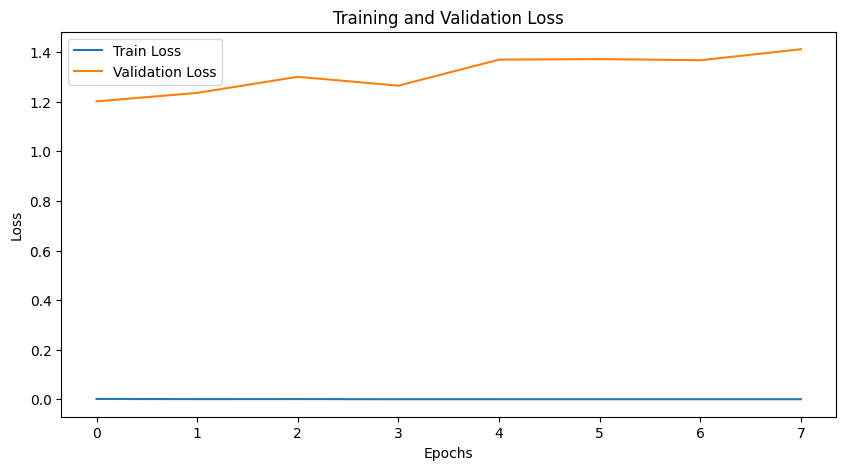

In [ ]:
# Plotando gráficos de perda
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
def predict_and_save_csv(model, test_loader, device, classes, output_file):
    model.eval()
    predictions = []

    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predicted_classes = [classes[idx] for idx in predicted.cpu().numpy()]

            # Pegar os nomes dos arquivos das imagens para o lote atual
            batch_indices = test_loader.batch_sampler.__iter__().__next__()
            file_names = [test_loader.dataset.files[i] for i in batch_indices]

            batch_predictions = zip(file_names, predicted_classes)
            predictions.extend(batch_predictions)

    # Salvar as previsões em um arquivo CSV
    df = pd.DataFrame(predictions, columns=['ID', 'class'])
    df.to_csv(output_file, sep = ',', index=False)
    print(f'Predictions saved to {output_file}')

In [ ]:
def predict_and_save_csv(model, test_loader, device, classes, output_file):
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch_idx, (images, _) in enumerate(test_loader):
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Calcula o índice inicial do arquivo no lote atual
            start_idx = batch_idx * test_loader.batch_size

            # Itera sobre as previsões e associa cada uma ao seu arquivo correspondente
            for i in range(images.size(0)):
                file_idx = start_idx + i
                file_name = test_loader.dataset.files[file_idx]
                predicted_class = classes[predicted[i].item()]
                predictions.append((file_name, predicted_class))

    # SALVANDO AS PREDIÇÕES EM CSV
    df = pd.DataFrame(predictions, columns=['ID', 'class'])
    df.to_csv(output_file, sep = ',', index=False)




In [ ]:
classes = ['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']
output_file = 'predictions2_.csv'

predict_and_save_csv(model, test_loader, device, classes, output_file)

**Sobreajuste**

A discrepância significativa entre a perda de treinamento (muito baixa) e a perda de validação (relativamente alta e crescente em épocas posteriores) sugere um claro sinal de sobreajuste. O sobreajuste ocorre quando o modelo aprende os detalhes e ruídos nos dados de treinamento a ponto de prejudicar sua capacidade de generalizar para novos dados. Isso é evidenciado pelo fato de que a perda de validação é substancialmente mais alta do que a perda de treinamento e não diminui na mesma proporção ao longo do treinamento.

Para resolver esse problema, tentamos utilizar algumas estratégias, como alterar o otimizador de Adam para SGD, reduzir o número de epochs de 10 para 8, mas não obtivemos sucesso. No entanto, a redução do número de epochs não alterou significativamente o resultado. Já A atribuição de pesos no schedule fez uma certa diferença.

Algumas outras estratégias podem ser utilizadas, como implementar técnicas de dropout e as regularização de L1 e L2. Por fim, a implementação da técnica de parada antecipada durante o treinamento poderia ser uma medida mais eficaz, pois ela permite interromper o processo de treinamento assim que a perda de validação começa a aumentar, evitando que o modelo aprenda demais os detalhes específicos do conjunto de treinamento em detrimento de sua habilidade de generalização.